# The Problem

The challenge we're faced with here is simple yet complex.  

We have some data about Milk Production and Milk Prices of a manufacturer in Brazil and we need to predict the `price_to_producer` for an horizon of a year.

## 1. EDA 

As always before digging into modelling and the nitty-gritty of forecasting and behaviour of our series, we need to take a good look at the data.

In [1]:
import pandas as pd 
from plotnine import (ggplot, aes, geom_line,facet_grid, theme_bw, labs)
from plotnine.options import set_option

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Reading the data
df = pd.read_csv("../data/tidy_data.csv", parse_dates=[0])

In [3]:
df.head()

,date,milk_production,imports,exports,total_supply,population,per_capita_supply,unemployment,wage_mass,uht_milk_industry,uht_milk_market,farmgate_milk_price
0,2007-01-01,1629.549,51.486829,37.232129,1643.803700,188.496928,8.720586,NaN,NaN,NaN,1.422492,0.450872
1,2007-02-01,1405.073,44.565910,39.461382,1410.177528,188.657245,7.474812,NaN,NaN,NaN,1.412007,0.480057
2,2007-03-01,1444.693,23.326896,40.938828,1427.081068,188.817561,7.557989,NaN,NaN,NaN,1.427207,0.500857
3,2007-04-01,1333.077,19.810018,33.958065,1318.928953,188.977878,6.979277,NaN,NaN,NaN,1.471410,0.544433
4,2007-05-01,1359.253,16.034976,45.073625,1330.214351,189.138194,7.033029,NaN,NaN,NaN,1.613760,0.586239


Alright! We can see we have some NaN values that we might or might not have to handle. 

Let's take a look at the variables we have.

For this task I'll be using the package `plotnine` so I can borrow the graphics of R ggplot into Python because they are quite aesthetic!

Let's break it down into `Supply Indicators` and `Demand Indicators` so we don't bloat our plots and we can see those variables separately.

In [4]:
cols_supply = ["date", "milk_production", "imports", "exports", "total_supply", "farmgate_milk_price"]
cols_demand = ["date", "unemployment", "uht_milk_industry", "uht_milk_market", "wage_mass", "farmgate_milk_price"]

supply_indicators = df.loc[:, cols_supply] 
demand_indicators = df.loc[:, cols_demand] 

df_supply_long = supply_indicators.melt(id_vars="date", var_name="name", value_name="value")
df_demand_long = demand_indicators.melt(id_vars="date", var_name="name", value_name="value")


## Supply Indicators

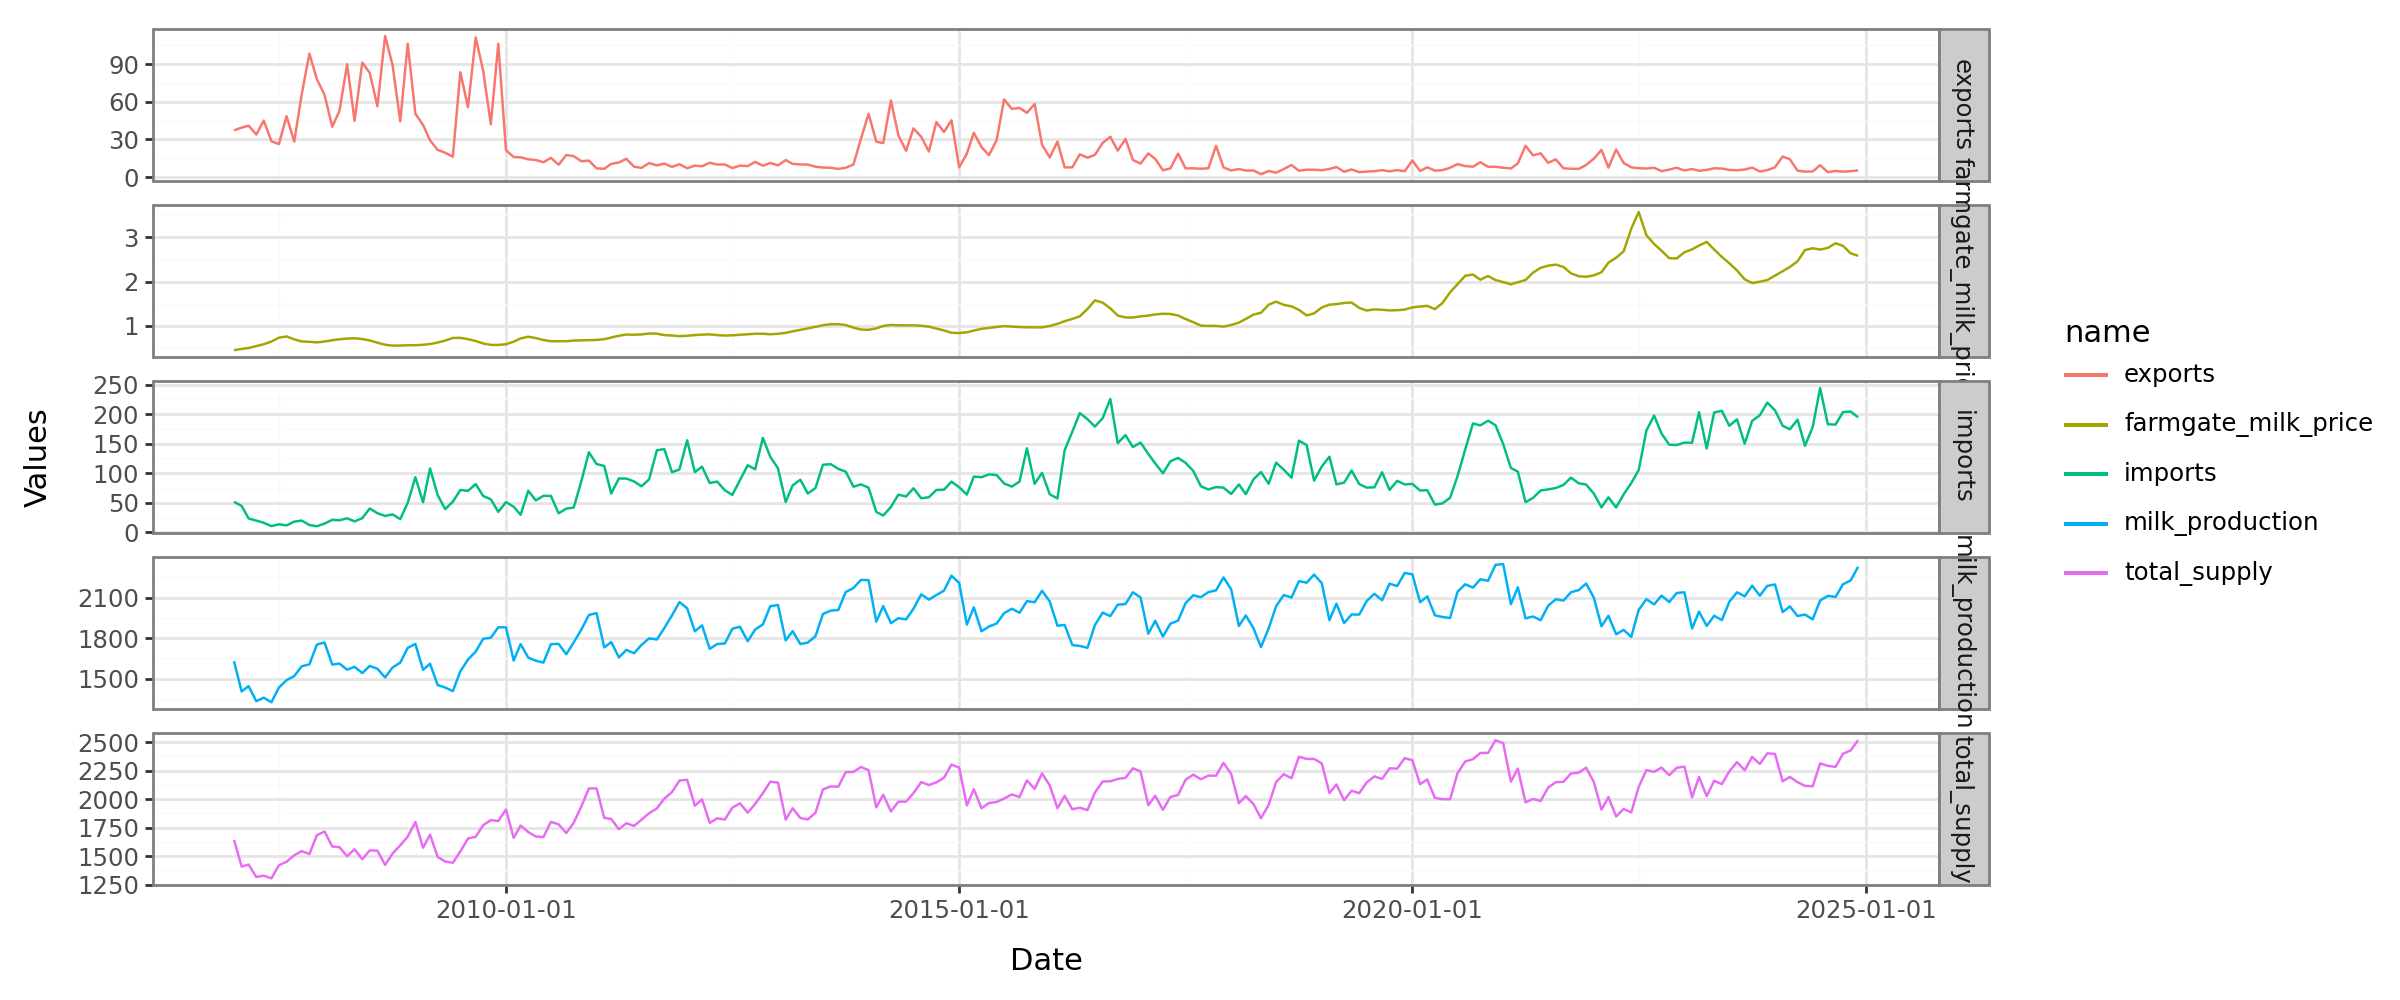

In [31]:

# plotnine version of ggplot
p = (
    ggplot(df_supply_long, aes(x="date", y="value", colour="name"))
    + geom_line()
    + facet_grid("name ~ .", scales="free_y")
    + theme_bw()
    + labs(x="Date", y="Values")
)

set_option("figure_size", (12, 4))

p

### Conclusions

1. So far, we can see by the plot that there's a strong correlation between `milk_production` and `total_supply`. They are pratically the same series. 

2. There's a clear upward trend in `farmgate_milk_price`. 

3. We can definitely see a clear seasonality on `total_supply` and `milk_production`. 

That being said, we know that our target time-series is not stationary and that there are some regressors that might help to model the signal of out time-series.

## Demand Indicators

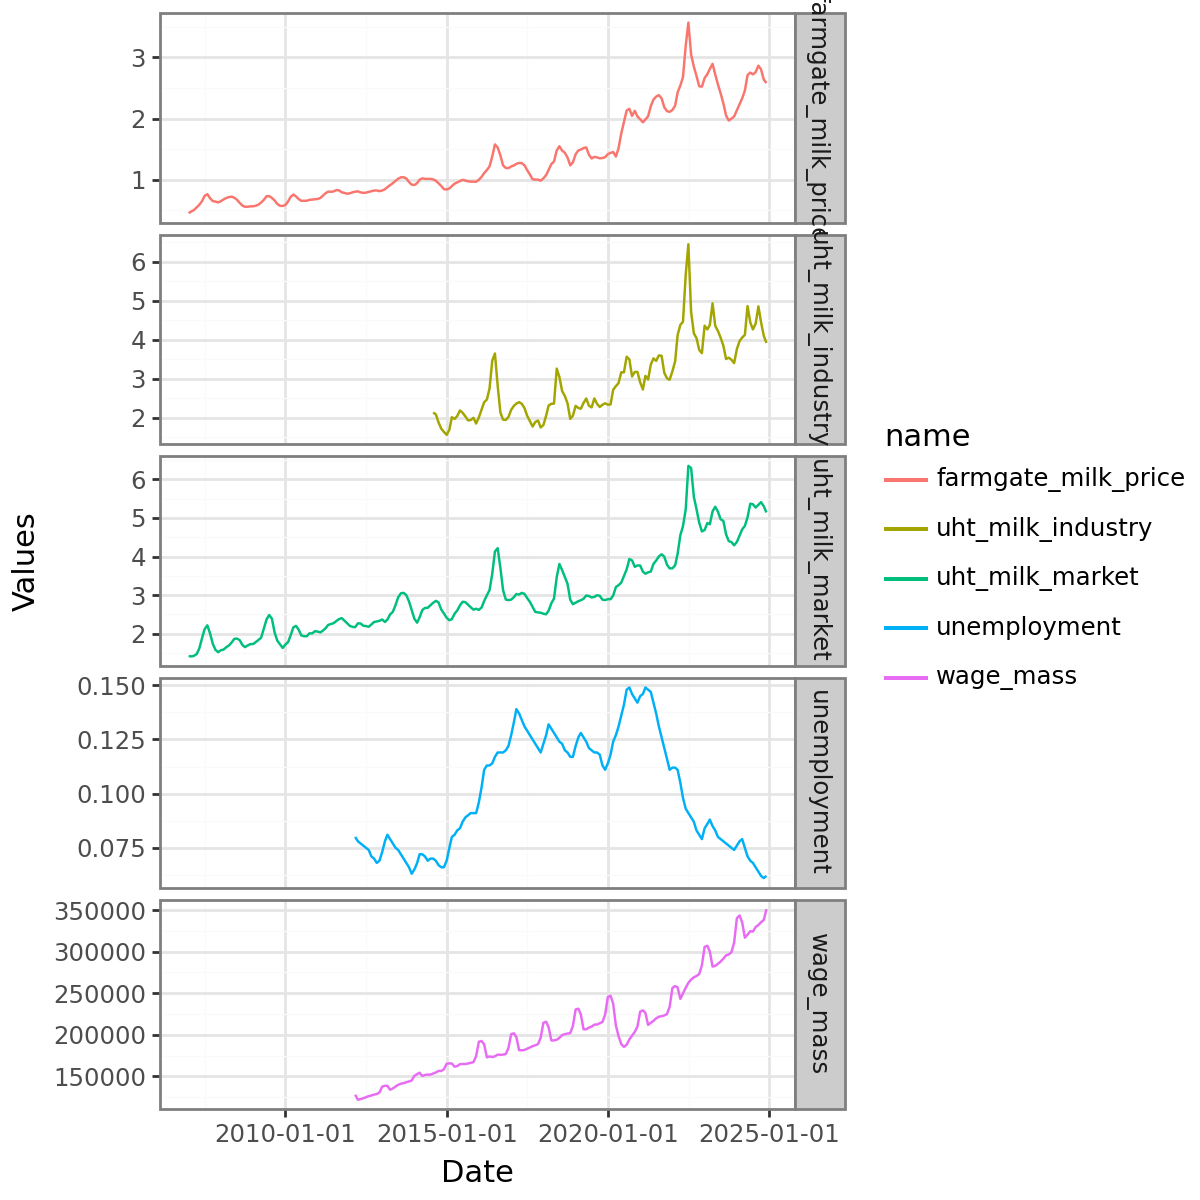

In [7]:

# plotnine version of ggplot
p = (
    ggplot(df_demand_long, aes(x="date", y="value", colour="name"))
    + geom_line()
    + facet_grid("name ~ .", scales="free_y")
    + theme_bw()
    + labs(x="Date", y="Values")
)

set_option("figure_size", (6, 6))

p

### Conclusions Demand Indicators

Alright, regarding the Demand Indicators we can see right away that there's missing data for the `uht_milk_industry` and for the `unemployment`. 
But, that's no problem because we probably don't need all that past data to forecast one year ahead.

1. We see a clearly correlation between `uht_milk_market` and `uht_milk_industry`. Which is very expected. We probably can delete one them if regressors are used. 

2. The `wage_mass` display a clear upward trend and a clear seasonality. Over the last 4 year we see a decreasing of unemployment.

3. There's a clear correlation between `uht_milk_market` and out target variable `farmgate_milk_price`. It seems that they are almost the same series, but the `uht_milk_market` has lower values.



# 2. Correlation

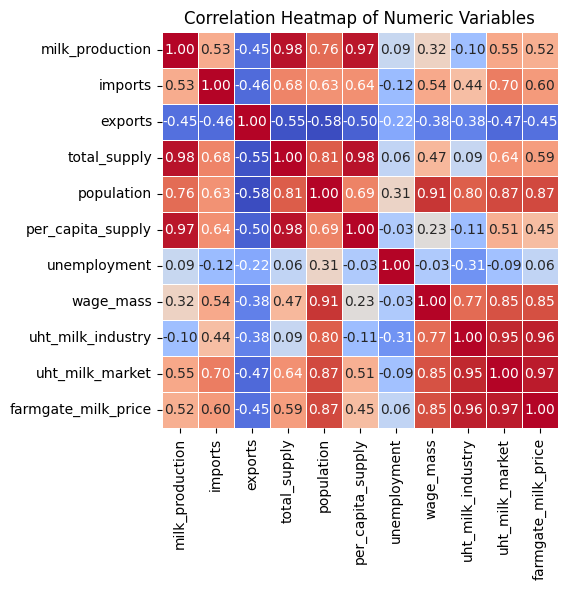

In [50]:


# Select only numeric columns
numeric_df = df.select_dtypes(include=np.number)

# Compute correlation matrix
corr = numeric_df.corr()

# Plot heatmap with annotations
plt.figure(figsize=(10, 8))
sns.heatma

## Null Values

We know that most ML and Econometrics models can't deal very well with Null values. 

We can see from the plots above that there are some Null values for the vearibles: `uht_milk_industry`, `unemplyment` and `wage_mass`.

In [49]:
df_with_nulls = df[df.isnull().any(axis=1)] 
print("Months with Null Values:", df_with_nulls.shape[0])

Months with Null Values: 91


In [45]:
print(df_with_nulls.date.min())
print(df_with_nulls.date.max())

2007-01-01 00:00:00
2014-07-01 00:00:00


We can see that the Nulls in our dataset happens from 2007 to 2014. And looking at the data, it seems that the data displayed a completely different behaviour back then compared to the last 10 years. 

With that in mind and given that our goal is to predict 12 months ahead and we have a total of 216 months, losing the first 91 months does not seem to be a dangerous thing.

With that in mind, we'll delete the data that contains Nulls for our exogenous variables.

## 2. Thinking about Modelling

Before we jump right on the modelling part that simple analysis gave us some insights on plausible approaches that we might take.

So, even though we don't have a stationary series - which seldom happens in practice - we do have a well behaved time-series for our target. 

Besides that, we also have variables that seems somewhat regular.

And giving that out target displays a linear trend and a linear behaviour somewhat, linear correlations seems plausible to analyse.

As always we must keep in mind that our goal is to extract all the signal, from the time-series as possible and try to derive some patterns from it